# Toronto Airbnb Price Prediction (Machine Learning Project)

This notebook builds an end-to-end machine learning pipeline to predict nightly Airbnb listing prices in Toronto using the **InsideAirbnb (Oct 2025)** dataset.  

We will:

- Explore 80+ listing, location, and host features  
- Clean and preprocess messy real-world data  
- Engineer meaningful features  
- Compare ML models such as Linear Regression, Random Forest, and **XGBoost**  
- Evaluate performance using RMSE, MAE, and R²  
- Identify the most important drivers of price  

The goal is to build a **reliable, interpretable model** that explains how host behavior, listing characteristics, reviews, and neighborhood factors influence Airbnb pricing in Toronto.


**IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb_model_lib
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

**Load Dataset**

In [2]:
# load dataset
df = pd.read_csv("bnb_listing.csv")

# dispaly shape and first rows
print("Shape: ", df.shape)
pd.set_option('display.max_columns', None)
df.head()

Shape:  (21316, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20251007145325,2025-10-08,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Vancouver, Canada","I live in Vancouver, Canada with my husband an...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/7aeea...,https://a0.muscache.com/im/pictures/user/7aeea...,Commercial Drive,1.0,2.0,"['email', 'phone']",t,t,Neighborhood highlights,Little Portugal,NaN,43.64590,-79.42423,Entire home,Entire home/apt,10,NaN,3 baths,5.0,NaN,"[""Indoor fireplace"", ""Smoke alarm"", ""First aid...",NaN,28,730,28.0,28.0,730.0,730.0,28.0,730.0,NaN,t,0,0,0,0,2025-10-08,6,0,0,0,0,0,NaN,2015-07-19,2017-08-07,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,1,1,0,0,0.05
1,8077,https://www.airbnb.com/rooms/8077,20251007145325,2025-10-08,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/9a077...,https://a0.muscache.com/im/pictures/user/9a077...,Harbourfront,2.0,3.0,"['email', 'phone']",t,f,NaN,Waterfront Communities-The Island,NaN,43.64080,-79.37673,Private room in rental unit,Private room,2,NaN,1.5 baths,NaN,NaN,"[""Smoke alarm"", ""Air conditioning"", ""Wifi"", ""F...",NaN,180,365,180.0,180.0,365.0,365.0,180.0,365.0,NaN,NaN,0,0,0,0,2025-10-08,167,0,0,0,0,0,NaN,2009-08-20,2013-08-27,4.83,4.81,4.89,4.87,4.90,4.92,4.83,NaN,f,2,1,1,0,0.85
2,26654,https://www.airbnb.com/rooms/26654,20251007145325,2025-10-08,city scrape,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,https://a0.muscache.com/pictures/81811785/5dcd...,113345,https://www.airbnb.com/users/show/113345,Adela,2010-04-25,NaN,Welcome to Toronto! \r\n\r\nAfter our first me...,within a day,75%,33%,t,https://a0.muscache.com/im/users/113345/profil...,https://a0.muscache.com/im/users/113345/profil...,Entertainment District,4.0,10.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Waterfront Communities-The Island,NaN,43.64608,-79.39032,Entire condo,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Housekeeping available 4 days a week - avail...",$120.00,28,1125,28.0,28.0,112

**Initial EDA**

In [3]:
# basic overview
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21316 entries, 0 to 21315
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21316 non-null  int64  
 1   listing_url                                   21316 non-null  object 
 2   scrape_id                                     21316 non-null  int64  
 3   last_scraped                                  21316 non-null  object 
 4   source                                        21316 non-null  object 
 5   name                                          21316 non-null  object 
 6   description                                   20939 non-null  object 
 7   neighborhood_overview                         9491 non-null   object 
 8   picture_url                                   21316 non-null  object 
 9   host_id                                       21316 non-null 

In [4]:
# missing values overview
df.isna().sum().sort_values(ascending=False)

,0
neighbourhood_group_cleansed,21316
calendar_updated,21316
host_neighbourhood,13837
neighborhood_overview,11825
neighbourhood,11824
...,...
instant_bookable,0
calculated_host_listings_count,0
calculated_host_listings_count_entire_homes,0
calculated_host_listings_count_private_rooms,0


In [5]:
# describe numerical cols
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.131600e+04,2.131600e+04,2.131600e+04,21298.000000,21298.000000,0.0,21316.000000,21316.000000,21316.000000,15656.000000,19620.000000,15657.000000,21316.000000,21316.000000,21301.000000,21301.000000,2.130100e+04,2.130100e+04,21316.000000,2.131600e+04,0.0,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,21316.000000,1.563900e+04,16565.000000,16563.000000,16564.000000,16563.000000,16563.000000,16562.000000,16563.000000,21316.000000,21316.000000,21316.000000,21316.000000,16565.000000
mean,6.982346e+17,2.025101e+13,2.468478e+08,6.690440,10.791342,NaN,43.684150,-79.397908,3.206981,1.300652,1.501937,1.784825,25.128964,446.387033,24.617389,27.544810,1.013876e+05,1.013936e+05,26.030658,1.013196e+05,NaN,11.816570,28.306390,46.063943,175.378870,30.347110,7.500891,0.815491,43.080034,6.089886,72.975746,1.531741e+04,4.781067,4.801983,4.738685,4.849042,4.865075,4.836513,4.697846,4.736724,2.108745,2.614327,0.009570,1.402842
std,5.854887e+17,2.664125e+00,2.267660e+08,18.474698,31.988556,NaN,0.050063,0.071375,2.031500,0.643163,0.984899,1.145019,39.030903,397.425554,38.596843,42.096486,1.471397e+07,1.471397e+07,39.608246,1.470879e+07,NaN,12.144503,24.377314,36.236480,136.934044,61.071647,14.299463,1.792880,34.482809,13.461685,90.557929,3.071732e+04,0.392744,0.386497,0.419554,0.348572,0.352899,0.300819,0.423541,11.744022,4.885342,10.497720,0.218974,1.813328
min,1.419000e+03,2.025101e+13,1.565000e+03,1.000000,1.000000,NaN,43.586470,-79.637273,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,3.522754e+07,2.025101e+13,3.827075e+07,1.000000,1.000000,NaN,43.646294,-79.430260,2.000000,1.000000,1.000000,1.000000,3.000000,100.000000,2.000000,5.000000,2.000000e+02,2.500000e+02,4.000000,2.400000e+02,NaN,0.000000,0.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.730000,4.770000,4.670000,4.830000,4.880000,4.800000,4.630000,1.000000,0.000000,0.000000,0.000000,0.180000
50%,8.468311e+17,2.025101e+13,1.655103e+08,2.000000,3.000000,NaN,43.665115,-79.397431,2.000000,1.000000,1.000000,1.000000,28.000000,365.000000,28.000000,28.000000,3.650000e+02,3.650000e+02,28.000000,3.650000e+02,NaN,7.000000,32.000000,54.000000,175.000000,7.000000,1.000000,0.000000,51.000000,0.000000,24.000000,6.720000e+03,4.890000,4.910000,4.870000,4.950000,4.970000,4.920000,4.800000,1.000000,1.000000,0.000000,0.000000,0.630000
75%,1.235938e+18,2.025101e+13,4.683690e+08,4.000000,7.000000,NaN,43.710307,-79.374040,4.000000,1.500000,2.000000,2.000000,28.000000,555.000000,28.000000,28.000000,1.125000e+03,1.125000e+03,28.000000,1.125000e+03,NaN,25.000000,54.000000,83.000000,312.000000,33.000000,8.000000,1.000000,78.000000,4.000000,126.000000,2.185500e+04,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.9300

In [6]:
# describe categorical cols
df.describe(include="object")

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
count,21316,21316,21316,21316,20939,9491,21316,21316,21298,21298,15646,9793,14980,14980,15492,20450,21298,21298,7479,21298,21298,21298,9492,21316,21316,21316,21294,21316,15639,20233,21316,16565,16565,10402,21316
unique,21316,2,2,20853,18719,8012,20849,14310,7394,4652,306,6032,4,61,96,2,13626,13626,327,8,2,2,1,140,58,4,28,20354,780,1,2,3527,2385,8083,2
top,https://www.airbnb.com/rooms/1525720053349356413,2025-10-08,city scrape,Home away from home,You'll have a great time at this comfortable p...,The lively Entertainment District lives up to ...,https://a0.muscache.com/pictures/hosting/Hosti...,https://www.airbnb.com/users/show/206663714,David,2018-08-01,"Toronto, Canada","We get one life to live, so make the most of t...",within an hour,100%,100%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Downtown Toronto,"['email', 'phone']",t,t,Neighborhood highlights,Waterfront Communities-The Island,Entire rental unit,Entire home/apt,1 bath,"[""Air conditioning"", ""Essentials"", ""Lock on be...",$100.00,t,2025-10-08,2023-04-30,2025-10-05,Exempt,f
freq,1,19367,15669,10,173,27,20,121,136,126,14047,100,10571,11745,5932,13298,880,880,754,17102,20412,19024,9492,3524,5434,14042,10221,39,187,20233,19367,45,547,130,16825


In [7]:
# check value counts for key categorical cols

df['room_type'].value_counts()

,count
room_type,
Entire home/apt,14042
Private room,7199
Shared room,58
Hotel room,17


In [8]:
df['property_type'].value_counts().head(20)

,count
property_type,
Entire rental unit,5434
Private room in home,4444
Entire condo,3547
Entire home,3351
Private room in rental unit,1183
Entire guest suite,762
Private room in condo,472
Private room in townhouse,343
Private room in bungalow,319


In [9]:
df['neighbourhood_cleansed'].value_counts()

,count
neighbourhood_cleansed,
Waterfront Communities-The Island,3524
Niagara,839
Annex,709
Church-Yonge Corridor,656
Kensington-Chinatown,558
...,...
Thorncliffe Park,22
Maple Leaf,21
Scarborough Village,20


In [10]:
df['host_response_time'].value_counts()

,count
host_response_time,
within an hour,10571
within a few hours,2461
within a day,1240
a few days or more,708


In [11]:
# check price col
df['price'].head()

,price
0,NaN
1,NaN
2,$120.00
3,NaN
4,NaN


In [12]:
df['price'].describe()

,price
count,15639
unique,780
top,$100.00
freq,187


**Dataset Cleaning**

select features

In [13]:
# keep only the relevant features

features = [
    # core listing features
    'accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'availability_365', 'property_type', 'room_type',

    # location based features
    'latitude', 'longitude', 'neighbourhood_cleansed',

    # host behaviour based features
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_total_listings_count', 'host_since', 'host_has_profile_pic', 'host_identity_verified',

    # listing review history based features
    'number_of_reviews', 'reviews_per_month', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',

    # target feature
    'price'
]

df = df[features].copy()
print("New Shape: ", df.shape)
df.head()

New Shape:  (21316, 29)


,accommodates,bedrooms,beds,bathrooms,minimum_nights,availability_365,property_type,room_type,latitude,longitude,neighbourhood_cleansed,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_since,host_has_profile_pic,host_identity_verified,number_of_reviews,reviews_per_month,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,10,5.0,NaN,NaN,28,0,Entire home,Entire home/apt,43.64590,-79.42423,Little Portugal,NaN,NaN,f,2.0,2008-08-08,t,t,6,0.05,2017-08-07,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN
1,2,NaN,NaN,NaN,180,0,Private room in rental unit,Private room,43.64080,-79.37673,Waterfront Communities-The Island,NaN,NaN,f,3.0,2009-06-22,t,f,167,0.85,2013-08-27,4.83,4.81,4.89,4.87,4.90,4.92,4.83,NaN
2,4,2.0,2.0,1.0,28,149,Entire condo,Entire home/apt,43.64608,-79.39032,Waterfront Communities-The Island,75%,33%,t,10.0,2010-04-25,t,t,45,0.25,2025-02-01,4.80,4.80,4.80,4.67,4.78,4.87,4.69,$120.00
3,1,NaN,NaN,NaN,365,0,Entire rental unit,Entire home/apt,43.66884,-79.32725,South Riverdale,NaN,NaN,f,1.0,2010-05-04,t,t,31,0.17,2025-01-01,4.93,5.00,4.88,5.00,5.00,4.88,4.88,NaN
4,2,1.0,NaN,NaN,180,0,Entire rental unit,Entire home/apt,43.64015,-79.37625,Waterfront Communities-The Island,NaN,NaN,f,3.0,2009-06-22,t,f,1,0.01,2010-08-11,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


clean price col

In [14]:
# convert to string to ensure consistency
df['price'] = df['price'].astype(str)

# remove $
df['price'] = df['price'].str.replace("$", "", regex=False)

# remove commas
df['price'] = df['price'].str.replace(",", "", regex=False)

# convert to float
df['price'] = df['price'].astype(float)

clena host response and acceptance rates

In [15]:
# define a func to clean % values
def clean_percentage(col):
    return (
        df[col]
        .astype(str) # ensure value is initially treated as string
        .str.replace("%", "", regex=False) # remove the % sign
        .replace("nan", np.nan) # replace "nan" wirh actual np.nan
        .astype(float) / 100 # convert to float and then into proportions
    )

In [16]:
df['host_response_rate'] = clean_percentage('host_response_rate')
df['host_acceptance_rate'] = clean_percentage('host_acceptance_rate')

clean boolean cols and convert t/f values to 0/1

In [17]:
bool_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']

for col in bool_cols:
  df[col] = df[col].map({'t': 1, 'f': 0})

clean date cols and create new features

In [18]:
# scrape date from the dataset
today = pd.Timestamp("2025-10-08")

# convert string date cols to datetime type
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# create new features

# since when the host joined airbnb
df['host_tenure_day'] = (today - df['host_since']).dt.days

# date of the most recent review
df['days_since_last_review'] = (today - df['last_review']).dt.days


In [19]:
# drop og date time cols
df = df.drop(columns=['host_since', 'last_review'], errors='ignore')

In [20]:
# drop rows with price null
df.dropna(subset=['price'], inplace=True)

In [21]:
# check null values in other cols
df.isna().sum()

,0
accommodates,0
bedrooms,18
beds,12
bathrooms,13
minimum_nights,0
availability_365,0
property_type,0
room_type,0
latitude,0
longitude,0


In [22]:
# handle missing values in other cols
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col + "_missing"] = df[col].isna().astype(int)

        if df[col].dtype == "object":
            df[col] = df[col].fillna("Unknown")
        else:
            df[col] = df[col].fillna(df[col].median())

In [23]:
# check price outliers
df['price'].describe()

,price
count,15639.00000
mean,182.77441
std,323.37492
min,9.00000
25%,79.00000
50%,131.00000
75%,214.00000
max,12600.00000


<Axes: >

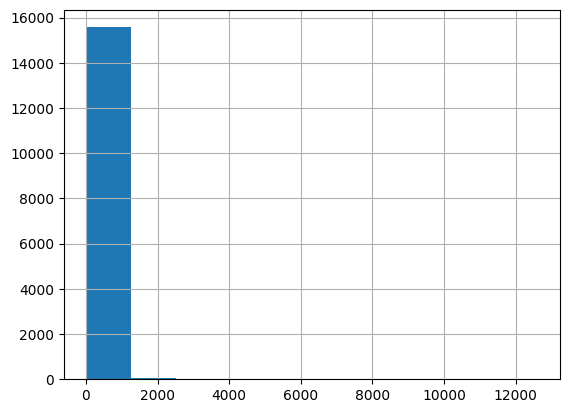

In [24]:
df['price'].hist()

In [25]:
# filter price outliers
# keep only "reasonable" prices (e.g., 1st–99th percentile)
low, high = df['price'].quantile([0.01, 0.99])
print(low, high)

df = df[(df['price'] >= low) & (df['price'] <= high)].copy()
print(df['price'].describe())

33.0 870.4799999999959
count    15333.000000
mean       165.009652
std        121.207914
min         33.000000
25%         80.000000
50%        131.000000
75%        212.000000
max        868.000000
Name: price, dtype: float64


In [26]:
# create log price target
df['log_price'] = np.log1p(df['price'])  # log(1 + price)

In [27]:
# keep only the top N most common neighborhoods, rest as 'Other'
top_neigh = df['neighbourhood_cleansed'].value_counts().index[:20]
df['neighbourhood_grouped'] = df['neighbourhood_cleansed'].where(
    df['neighbourhood_cleansed'].isin(top_neigh),
    'Other'
)

df = df.drop(columns=['neighbourhood_cleansed'])

In [28]:
# target encode simplified neighborhood
neigh_mean = df.groupby('neighbourhood_grouped')['price'].mean()
df['neighbourhood_encoded'] = df['neighbourhood_grouped'].map(neigh_mean)
df = df.drop(columns=['neighbourhood_grouped'])

**Feature Engineering**

In [29]:
# avoid divide by zero
acc = df['accommodates'].replace(0, np.nan)
df['beds_per_guest'] = df['beds'] / acc
df['bathrooms_per_guest'] = df['bathrooms'] / acc
df['bedrooms_per_guest'] = df['bedrooms'] / acc
df['availability_ratio'] = df['availability_365'] / 365


**One Hot Encoding**

In [30]:
df = pd.get_dummies(df, drop_first=True)

**Modeling**

In [31]:
# train-test split

X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
# store results for comparision
results = []

In [33]:
# helper to report metrics in both log and $ space
def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # convert back from log scale to $ for metrics
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    r2 = r2_score(y_test, pred)
    rmse = mean_squared_error(y_test_exp, pred_exp)
    mae = mean_absolute_error(y_test_exp, pred_exp)

    print(f"{name:20} | R²: {r2:.3f} | RMSE: ${rmse:,.0f} | MAE: ${mae:,.0f}")

    # save for summary
    results.append({
        "Model": name,
        "R²": round(r2, 3),
        "RMSE ($)": round(rmse, 0),
        "MAE ($)": round(mae, 0)
    })

    return model


In [34]:
# model 1 — linear regression
lr = LinearRegression()
lr = eval_model("Linear Regression", lr)

Linear Regression    | R²: 0.681 | RMSE: $6,569 | MAE: $50


In [35]:
# model 2 — random forest
eval_model("Random Forest", RandomForestRegressor(n_estimators=300))


Random Forest        | R²: 0.751 | RMSE: $5,553 | MAE: $44


RandomForestRegressor(n_estimators=300)

In [36]:
# model 3 - XGBoost

xgb = eval_model("XGBoost", XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
))


XGBoost              | R²: 0.770 | RMSE: $5,047 | MAE: $42


**Evaluation**

In [37]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R²", ascending=False)
results_df

,Model,R²,RMSE ($),MAE ($)
2,XGBoost,0.770,5047.0,42.0
1,Random Forest,0.751,5553.0,44.0
0,Linear Regression,0.681,6569.0,50.0


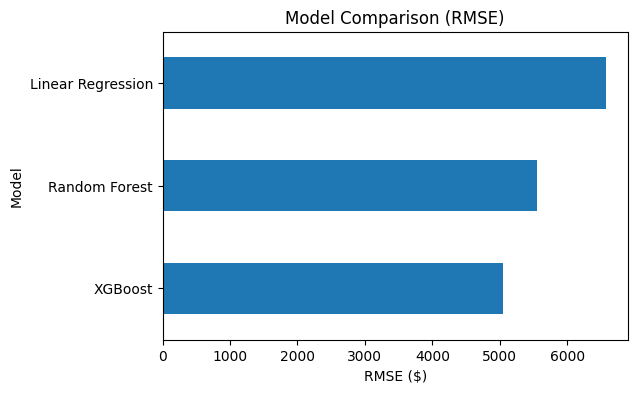

In [38]:
results_df.plot(x="Model", y="RMSE ($)", kind="barh", legend=False, figsize=(6,4))
plt.title("Model Comparison (RMSE)")
plt.xlabel("RMSE ($)")
plt.show()

**Feature Importance**

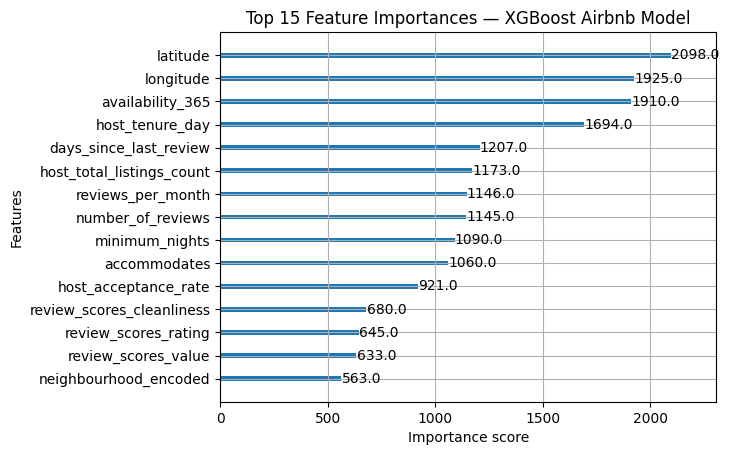

In [39]:
# extract and plot top 15 important features
xgb_model_lib.plot_importance(xgb, max_num_features=15)
plt.title("Top 15 Feature Importances — XGBoost Airbnb Model")
plt.xlabel("Importance score")
plt.show()

**Conclusion**

In this project, we built an end-to-end machine learning workflow to predict nightly Airbnb listing prices in Toronto using the InsideAirbnb dataset. Starting with 21K raw listings and 80+ features, we performed extensive data cleaning, engineered meaningful features, handled categorical variables, and evaluated multiple regression models.

**Model Performance Summary**

1. XGBoost:
  - R² : ~0.77

  - RMSE `($)` : ~$5,047

  - MAE `($)` : ~$42

2. Random Forest:
  - R² : ~0.75

  - RMSE `($)` : ~$5,553

  - MAE `($)` : ~$44

3. Linear Regression:
  - R² : ~0.68

  - RMSE `($)` : ~$6,569
  
  - MAE `($)` : ~$50


Key Takeaways
- XGBoost performed best, capturing ~77% of price variance and improving RMSE by ~24% vs linear regression.
- Spatial features (latitude, longitude) and availability were the strongest drivers of price.
- Host behavior features like host tenure, acceptance rate, and total listing count meaningfully influence earnings.
- Using target encoding and feature engineering helped simplify high-cardinality variables like neighborhoods and improve model interpretability.

What This Means
- Price variation in Toronto Airbnb listings is driven primarily by location, host experience, and listing availability.
- Even without deep neural networks or heavy hyperparameter tuning, tree-based models provide strong baseline performance.
- The trained model can now be extended into an interactive prediction tool (e.g. Streamlit app) or deployed as an API.

Limitations
- No direct text analysis of listing descriptions or amenities
- No supply/demand seasonality adjustments
- Price target is based on current listing price—not actual transaction data

Future Improvements
- Hyperparameter tuning (GridSearch / Optuna)
- SHAP or LIME for model explainability
- Geospatial / map visualizations
- Time-based features (seasonality, event spikes)
- Transformer model for text feature extraction
- Deploy a lightweight prediction web app